In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from scipy.stats import randint
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import xgboost as xgb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/Data_SQL

/content/drive/MyDrive/Data_SQL


# Importing data

In [ ]:
ls


24_SQLI.csv             metrics_chunk_0.txt              random_forest_model_best_v4.pkl
arr_0.csv               metrics_chunk_1.txt              somepatharr_0.csv
bert_model_BCELoss.pth  model_chunk_0.pkl                SQLi.npz
bert_model.pth          model_chunk_1.pkl                Untitled0.ipynb
data_layer2.csv         random_forest_model_best.pkl     wrong_predictions.csv
Final_Attacks.csv       random_forest_model_best_v1.pkl  wrong_predictions_final.csv
Final_Vaild.csv         random_forest_model_best_v2.pkl
Final_Vaild_V2.csv      random_forest_model_best_v3.pkl


In [ ]:
df=pd.read_csv("Final_Vaild_V2.csv")
df

<ipython-input-26-7d8b7e8e0716>:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv("Final_Vaild_V2.csv")


,Unnamed: 0,entry,label
0,0,CREATE SCHEMA /*!IF NOT EXISTS*/ schema;,0
1,1,DROP TABLE /*! IF EXISTS*/ table0_int_autoinc;,0
2,2,CREATE TABLE `table0_int_autoinc` (,0
3,3,CREATE INDEX idx_table0_int_autoinc_`col_set_l...,0
4,4,CREATE INDEX idx_table0_int_autoinc_`col_enum_...,0
...,...,...,...
1019481,1019481,DELETE FROM door WHERE grow = 'small',0
1019482,1019482,DELETE FROM tomorrow,0
1019483,1019483,SELECT wide ( s ) FROM west,0
1019484,1019484,SELECT * FROM ( SELECT slide FROM breath ),0


In [ ]:
df2=pd.read_csv("Final_Attacks.csv")
df2

<ipython-input-28-8c900f271fd6>:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df2=pd.read_csv("Final_Attacks.csv")


,entry,label
0,SELECT `col2` FROM `tab` WHERE `col1` LIKE '%'...,1
1,"DELETE FROM `tab` WHERE `col2` < ""exec sp_addl...",1
2,"INSERT INTO `tab` ( `col2`, `col2` ) VALUES ( ...",1
3,"--"" );",1
4,"INSERT INTO `tab` ( `col1` ) VALUES ( '"" OR EL...",1
...,...,...
1298200,â or 1 = 1 --,1
1298201,or 'x' = 'x,1
1298202,29%,1
1298203,28%,1


#Preprocessing for SQL Injection Detection

### 1 Converting to Lower Case

Standardizing all SQL query text to lower case helps in maintaining uniformity and reduces complexity during data processing.
### 2 Converting Label to Numeric

Transforming categorical labels into numerical values is essential for machine learning models to perform classifications effectively.
### 3 Removing Missing Data

Eliminating rows or columns with missing data ensures the robustness and accuracy of the model, leading to more reliable detection outcomes

In [ ]:
df['entry'] = df['entry'].astype(str)
df['entry'] = df['entry'].str.lower()
df['label'] = pd.to_numeric(df['label'], errors='coerce')
df['label'] = df['label'].astype('Int64')

In [ ]:
df2['entry'] = df2['entry'].astype(str)
df2['entry'] = df2['entry'].str.lower()
df2['label'] = pd.to_numeric(df2['label'], errors='coerce')
df2['label'] = df2['label'].astype('Int64')

In [ ]:
df.drop_duplicates()
df2.drop_duplicates()
df2.dropna()
df.dropna()
df.drop(columns=['Unnamed: 0'], inplace=True)

#Final Training and Testing Data for SQL Injection Detection

### Balanced Label Distribution
Ensuring an equal distribution of labels (50% label 1 and 50% label 0) promotes model fairness and prevents bias, leading to a more accurate evaluation of SQL injection threats

In [ ]:
sample_0 = df.sample(n=1000000, random_state=42)
smaple_1=df2.sample(n=1000000,random_state=27)
Final_df_ = pd.concat([sample_0, smaple_1], ignore_index=True)
Final_df_

,entry,label
0,"select `col1`, `col3`, `col3` from `tab` where...",0
1,update `tab` set `col1` = 6 where `col3` = 180...,0
2,insert into `tab` ( `col1` ) values ( 52461568...,0
3,update `tab` set `col3` = 9 where `col1` = -13...,0
4,delete from `tab` where `col2` >= -241172480 l...,0
...,...,...
1999995,"delete from `tab` where `col2` like ""%'l'%"" li...",1
1999996,"update `tab` set `col1` = 6 where `col3` >= ""'...",1
1999997,"select `col1`, `col3`, `col3` from `tab` where...",1
1999998,"select * from `tab` where `col2` = '3"")) union...",1


In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import torch.nn as nn


#Building Custom Dataset for SQL Injection Detection

### 1 Processing Data Using DataLoader

Utilizing a DataLoader streamlines the process of feeding data into the BERT model by efficiently managing data loading and transformations.
### 2 Converting to Batches

Batch processing is essential for training the BERT model, as it helps in handling large datasets effectively and improves the learning process.

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, texts, labels, vectorizer):
        self.texts = texts
        self.labels = labels
        self.vectorizer = vectorizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        # Convert text to numerical representation
        text_vectorized = self.vectorizer.transform([text]).toarray()
        return torch.tensor(text_vectorized), torch.tensor(label)



texts = Final_df_['entry'].tolist()
labels = Final_df_['label'].tolist()

# Split data into train and test sets
texts_train, texts_test, labels_train, labels_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Initialize CountVectorizer (you can use other tokenizers/embeddings as needed)
vectorizer = CountVectorizer()
vectorizer.fit(texts_train)

# Create custom datasets
train_dataset = CustomDataset(texts_train, labels_train, vectorizer)
test_dataset = CustomDataset(texts_test, labels_test, vectorizer)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Now you can use train_loader and test_loader to iterate over batches of data in your neural network model

# Final Formatting of Data for SQL Injection Detection

### 1 Converting to Input IDs

Transforming text data into input IDs is vital for token representation in BERT, which understands and processes these tokens.
### 2 Attention Mask
Creating attention masks helps the BERT model focus on relevant tokens, enhancing the effectiveness of the model in detecting SQL injections.

### 3 Labels

Assigning labels to data points is crucial for supervised learning, allowing the model to learn from examples and make accurate predictions.

In [ ]:
import torch
from transformers import BertTokenizer
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Split data into train and test sets
texts_train, texts_test, labels_train, labels_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Create custom datasets
train_dataset = CustomDataset(texts_train, labels_train, tokenizer)
test_dataset = CustomDataset(texts_test, labels_test, tokenizer)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [ ]:
test_loader

# Training Loop for SQL Injection Detection

### Training Loop for 10 Epochs
Running the training process for 10 epochs allows the model to iteratively learn from the dataset, optimizing its performance on SQL injection detection tasks.

In [ ]:
import torch
import torch.nn as nn
from transformers import BertForSequenceClassification, AdamW
from tqdm import tqdm

# Define BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)  # Adjust num_labels according to your classification task

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=2e-5)  # You can experiment with different learning rates
criterion = nn.BCELoss()
num_epochs=10
# Training loop
model.train()
for epoch in range(num_epochs):
    epoch_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        _, predicted = torch.max(logits, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_accuracy = correct_preds / total_preds
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss}, Accuracy: {epoch_accuracy}')

# Evaluation
model.eval()
eval_loss = 0.0
correct_preds = 0
total_preds = 0

with torch.no_grad():
    for batch in tqdm(test_loader, desc='Evaluation', unit='batch'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        _, predicted = torch.max(logits, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)

        eval_loss += loss.item()

eval_accuracy = correct_preds / total_preds
print(f'Evaluation Loss: {eval_loss}, Evaluation Accuracy: {eval_accuracy}')


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/1:   0%|          | 0/2500 [01:26<?, ?batch/s]


KeyboardInterrupt: 

#Importing Model for SQL Injection Detection Testing

### Importing Model and Tokenizer
Loading the pre-trained model along with its tokenizer is essential for preparing the test data in a format compatible with the model for effective SQL injection testing.

In [ ]:
import torch
from transformers import BertForSequenceClassification, BertTokenizer

# Load the fine-tuned BERT model
model_path = 'bert_model_BCELoss.pth'
# model = torch.load(model_path,map_location ='cpu')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.load_state_dict(torch.load(model_path))

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.to('cuda')

#Plotting Confusion Matrix for SQL Injection Detection

### Building Confusion Matrix
Constructing a confusion matrix for a dataset of 200,000 entries provides a clear visualization of the model's performance, highlighting its precision in detecting and classifying SQL injection attacks.

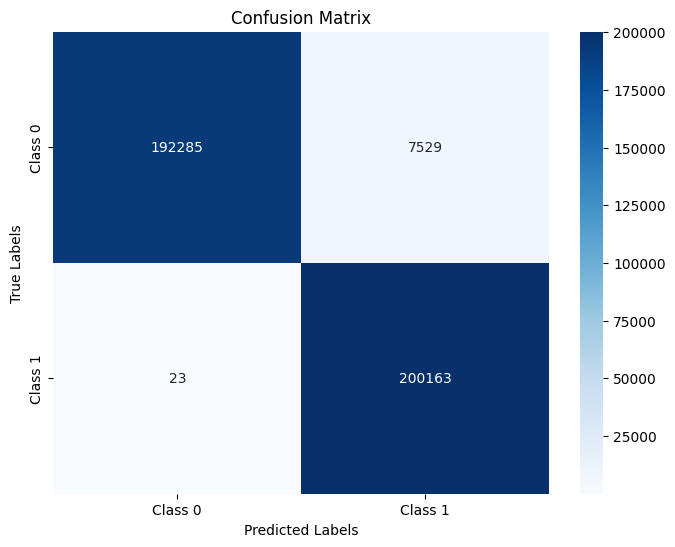

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Predict labels for the test dataset
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        _, predicted = torch.max(logits, 1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Build confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# Exploratory Data Analysis for Incorrect Predictions in SQL Injection Detection

Exploratory Data Analysis (EDA) for Incorrect Predictions
Conducting EDA on incorrect predictions helps identify patterns or common characteristics in misclassified data, enabling improvements in model accuracy.

In [ ]:
import csv

# Define the file name for the CSV
csv_file = "wrong_predictions_final.csv"

# Write wrong predictions to CSV
with open(csv_file, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(['Index', 'Text', 'True Label', 'Predicted Label'])

    for i, (text, true_label, predicted_label) in enumerate(wrong_predictions_text):
        writer.writerow([i, text, true_label, predicted_label])

print(f"Wrong predictions saved to {csv_file}")


Wrong predictions saved to wrong_predictions_final.csv


In [ ]:
worng=pd.read_csv("data_layer2.csv")
worng

,entry,Label
0,insert into `tab` ( `col2` ) values ( 'l' );,0
1,insert into `tab` ( `col2` ) values ( 'f' );,0
2,update `tab` set `col3` = 5 where `col1` like ...,0
3,update `tab` set `col1` = 1 where `col3` = 'r';,0
4,update `tab` set `col2` = 6 where `col1` like ...,0
...,...,...
7050,delete from `tab` where `col3` like '%'x'%';,0
7051,select `col3` from `tab` where `col3` like '%'...,0
7052,"select `col2`, `col3`, `col2`, `col1` from `ta...",0
7053,update `tab` set `col1` = 9 where `col1` like ...,0


In [ ]:
worng.iloc[0].Text

"select `col1`, `col1`, `col2` from `tab` where `col3` like '%'q'%';"

# Creating a CSV for Incorrect Predictions in SQL Injection Detection

### Generating CSV for Incorrect Predictions
Creating a CSV file with detailed columns like 'Total_Words', 'Total_Chars', 'Unique_Chars', and 'Size_of_Text' to analyze misclassified cases thoroughly and refine detection strategies.

In [ ]:
def calculate_metrics(text):
    total_words = len(text.split())
    total_chars = len(text)
    unique_chars = len(set(text))
    size_of_text = len(text.encode('utf-8'))
    return total_words, total_chars, unique_chars, size_of_text

# Apply the function to the "Text" column and store results in new columns
worng[['Total_Words', 'Total_Chars', 'Unique_Chars', 'Size_of_Text']] = worng['Text'].apply(lambda x: pd.Series(calculate_metrics(x)))

# Print the updated DataFrame
worng

,Index,Text,True Label,Predicted Label,Total_Words,Total_Chars,Unique_Chars,Size_of_Text
0,0,"select `col1`, `col1`, `col2` from `tab` where...",0,1,10,67,25,67
1,1,"select `col3`, `col3`, `col2` from `tab` where...",0,1,10,60,21,60
2,2,select * from `tab` where `col3` like '%'j'%';,0,1,8,46,23,46
3,3,insert into `tab` ( `col3` ) values ( 'o' );,0,1,10,44,20,44
4,4,"select `col2` from `tab` where `col1` like ""%'...",0,1,8,51,23,51
...,...,...,...,...,...,...,...,...
736,736,"select `col1`, `col1`, `col1`, `col2` from `ta...",0,1,23,139,25,139
737,737,delete from `tab` where `col3` like '%'r'%';,0,1,7,44,21,44
738,738,delete from `tab` where `col2` like '%'i'%' an...,0,1,11,71,23,71
739,739,update `tab` set `col3` = 9 where `col1` like ...,0,1,10,54,26,54



#Plotting Graphs for Analysis of SQL Injection Detection Data

### Graphical Analysis of Text Features
Plotting graphs for features like 'Total_Words', 'Size_of_Text', 'Unique_Chars', and 'Total_Chars' to visually examine the distribution and impact of these metrics on SQL injection detection outcomes.

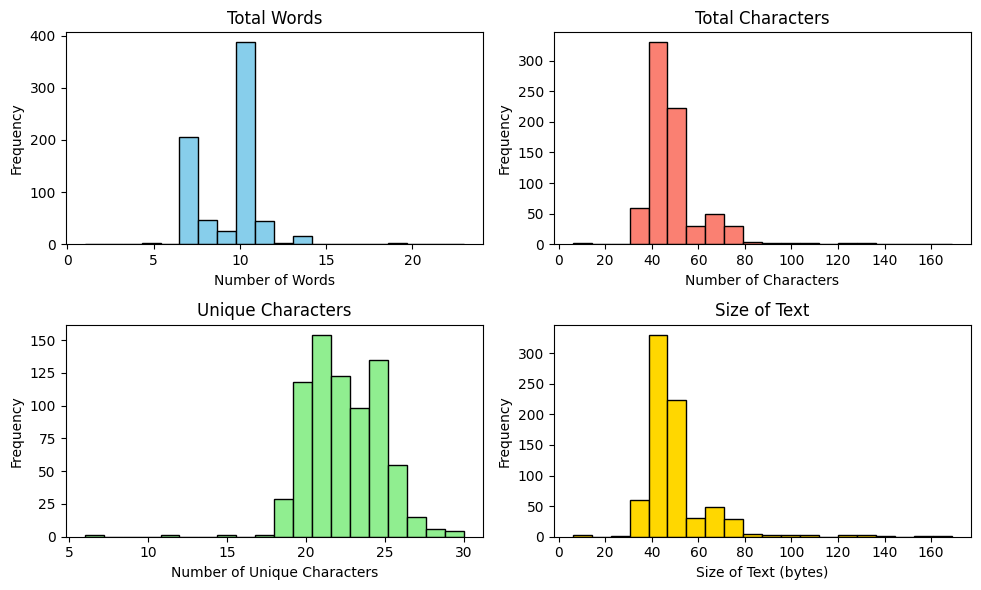

In [ ]:
plt.figure(figsize=(10, 6))

# Total Words
plt.subplot(2, 2, 1)
plt.hist(worng['Total_Words'], bins=20, color='skyblue', edgecolor='black')
plt.title('Total Words')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

# Total Chars
plt.subplot(2, 2, 2)
plt.hist(worng['Total_Chars'], bins=20, color='salmon', edgecolor='black')
plt.title('Total Characters')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')

# Unique Chars
plt.subplot(2, 2, 3)
plt.hist(worng['Unique_Chars'], bins=20, color='lightgreen', edgecolor='black')
plt.title('Unique Characters')
plt.xlabel('Number of Unique Characters')
plt.ylabel('Frequency')

# Size of Text
plt.subplot(2, 2, 4)
plt.hist(worng['Size_of_Text'], bins=20, color='gold', edgecolor='black')
plt.title('Size of Text')
plt.xlabel('Size of Text (bytes)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
def calculate_metrics(text):
    total_words = len(text.split())
    total_chars = len(text)
    unique_chars = len(set(text))
    size_of_text = len(text.encode('utf-8'))
    return total_words, total_chars, unique_chars, size_of_text

# Apply the function to the "Text" column and store results in new columns
Final_df_[['Total_Words', 'Total_Chars', 'Unique_Chars', 'Size_of_Text']] = Final_df_['entry'].apply(lambda x: pd.Series(calculate_metrics(x)))

# Print the updated DataFrame
Final_df_

,entry,label,Total_Words,Total_Chars,Unique_Chars,Size_of_Text
0,"select `col1`, `col3`, `col3` from `tab` where...",0,12,87,29,87
1,update `tab` set `col1` = 6 where `col3` = 180...,0,12,71,29,71
2,insert into `tab` ( `col1` ) values ( 52461568...,0,10,50,25,50
3,update `tab` set `col3` = 9 where `col1` = -13...,0,12,72,31,72
4,delete from `tab` where `col2` >= -241172480 l...,0,9,61,29,61
...,...,...,...,...,...,...
199995,delete from `tab` where `col3` = 'v';,1,7,37,20,37
199996,"' or `col2` = '"") as veow where 2949=2949;",1,9,42,20,42
199997,update `tab` set `col2` = 2 where `col1` like ...,1,18,185,40,185
199998,"insert into `tab` ( `col1` ) values ( ""' or 21...",1,17,112,35,112


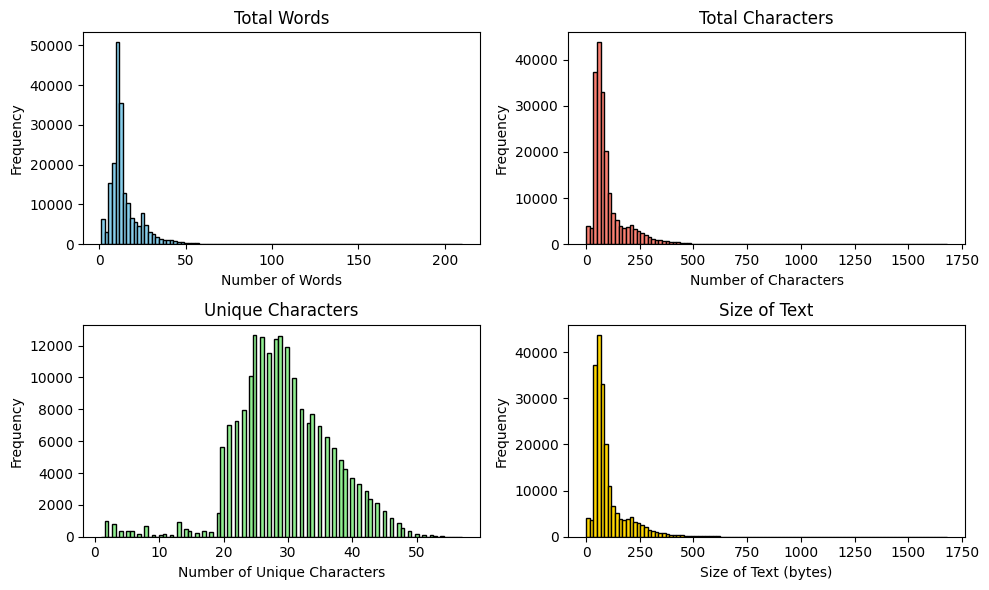

In [ ]:
plt.figure(figsize=(10, 6))

# Total Words
plt.subplot(2, 2, 1)
plt.hist(Final_df_['Total_Words'], bins=100, color='skyblue', edgecolor='black')
plt.title('Total Words')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

# Total Chars
plt.subplot(2, 2, 2)
plt.hist(Final_df_['Total_Chars'], bins=100, color='salmon', edgecolor='black')
plt.title('Total Characters')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')

# Unique Chars
plt.subplot(2, 2, 3)
plt.hist(Final_df_['Unique_Chars'], bins=100, color='lightgreen', edgecolor='black')
plt.title('Unique Characters')
plt.xlabel('Number of Unique Characters')
plt.ylabel('Frequency')

# Size of Text
plt.subplot(2, 2, 4)
plt.hist(Final_df_['Size_of_Text'], bins=100, color='gold', edgecolor='black')
plt.title('Size of Text')
plt.xlabel('Size of Text (bytes)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

#Special Character Analysis for SQL Injection Detection Training

### Analyzing Special Characters in Training Data
Conducting an analysis of special characters within the training dataset helps identify potentially malicious patterns unique to SQL injection attacks, improving the detection capabilities of the model.

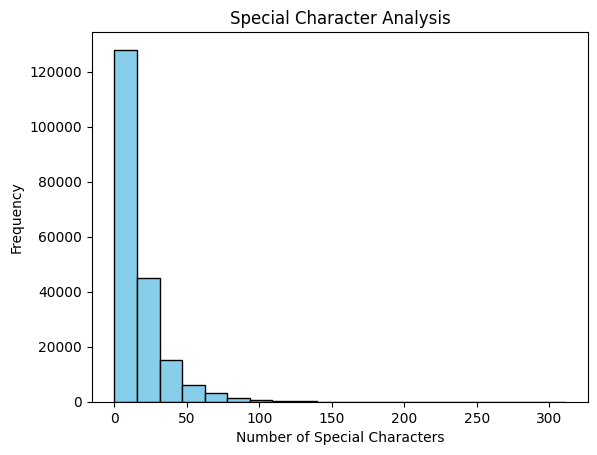

In [ ]:
special_chars_count = Final_df_['entry'].apply(lambda x: sum(c in "!@#$%^&*()_+{}[]|\;:'<>,.?/~`" for c in x))

# Plot histogram of special character counts
plt.hist(special_chars_count, bins=20, color='skyblue', edgecolor='black')
plt.title('Special Character Analysis')
plt.xlabel('Number of Special Characters')
plt.ylabel('Frequency')
plt.show()

#Special Character Analysis for Incorrect Predictions in SQL Injection Detection

### Analyzing Special Characters in Incorrect Predictions
Examining the role of special characters in the instances where the model incorrectly predicts outcomes can reveal insights into why these errors occur, aiding in model refinement.

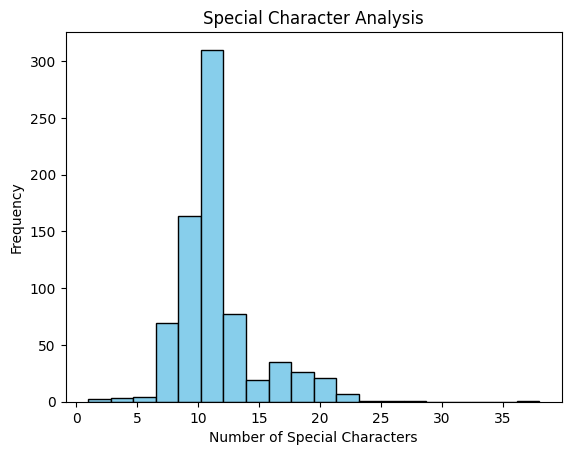

In [ ]:
special_chars_count = worng['Text'].apply(lambda x: sum(c in "!@#$%^&*()_+{}[]|\;:'<>,.?/~`" for c in x))

# Plot histogram of special character counts
plt.hist(special_chars_count, bins=20, color='skyblue', edgecolor='black')
plt.title('Special Character Analysis')
plt.xlabel('Number of Special Characters')
plt.ylabel('Frequency')
plt.show()

#Analysis of SQL Query Types for Injection Detection

### Queries Attempting to Bypass Access Controls

Examining queries that try to circumvent security measures provides insights into methods attackers use to gain unauthorized access.
### Queries with Input Validation Failures

Analyzing queries that fail input validation highlights vulnerabilities that can be exploited by SQL injection attacks.
### Time-Delayed Queries

Reviewing queries that introduce delays can indicate attempts to probe database vulnerabilities through time-based SQL injection techniques.
### Queries with UNION Keyword

Investigating the use of the UNION keyword helps identify SQL injections aiming to retrieve additional data from the database.
### Queries with Error Messages

Analyzing queries that result in error messages can uncover potential points of failure and exploitation in the system.
### Percentage of Parameterized Queries

Calculating the percentage of parameterized queries provides a measure of how many queries are safeguarded against SQL injection by using parameters instead of concatenating strings.


In [ ]:
parameterized_count = worng['Text'].str.contains(r'\?').sum()
total_queries = len(df)

print(f"Percentage of parameterized queries: {(parameterized_count / total_queries) * 100:.2f}%")

Percentage of parameterized queries: 0.00%


In [ ]:
parameterized_count = Final_df_['entry'].str.contains(r'\?').sum()
total_queries = len(df)

print(f"Percentage of parameterized queries: {(parameterized_count / total_queries) * 100:.2f}%")

Percentage of parameterized queries: 0.03%


In [ ]:
error_queries = Final_df_[Final_df_['entry'].str.contains('error', case=False, na=False)]
print("Queries with error messages:")
print(error_queries)

Queries with error messages:
Empty DataFrame
Columns: [entry, label, Total_Words, Total_Chars, Unique_Chars, Size_of_Text]
Index: []


In [ ]:
union_queries = Final_df_[Final_df_['entry'].str.contains('UNION', case=False, na=False)]
print("Queries with UNION keyword:")
print(len(union_queries))

Queries with UNION keyword:
11793


In [ ]:
union_queries = worng[worng['Text'].str.contains('UNION', case=False, na=False)]
print("Queries with UNION keyword:")
print(len(union_queries))

Queries with UNION keyword:
0


In [ ]:
time_delayed_queries = worng[worng['Text'].str.contains('WAITFOR DELAY', case=False, na=False)]
print("Time-delayed queries:")
print(len(time_delayed_queries))

Time-delayed queries:
0


In [ ]:
time_delayed_queries = Final_df_[Final_df_['entry'].str.contains('WAITFOR DELAY', case=False, na=False)]
print("Time-delayed queries:")
print(len(time_delayed_queries))

Time-delayed queries:
5041


In [ ]:
# Check for input validation failures
validation_failures = Final_df_[Final_df_['entry'].str.contains(r'\bEXEC\b|\bEXECUTE\b', case=False, na=False)]
print("Queries with input validation failures:")
print(len(validation_failures))

Queries with input validation failures:
2457


In [ ]:
# Check for input validation failures
validation_failures = worng[worng['Text'].str.contains(r'\bEXEC\b|\bEXECUTE\b', case=False, na=False)]
print("Queries with input validation failures:")
print(len(validation_failures))

Queries with input validation failures:
0


In [ ]:
# Identify access control bypass attempts
access_control_bypass = worng[worng['Text'].str.contains('GRANT|REVOKE', case=False, na=False)]
print("Queries attempting to bypass access controls:")
print(access_control_bypass)


Queries attempting to bypass access controls:
Empty DataFrame
Columns: [Index, Text, True Label, Predicted Label, Total_Words, Total_Chars, Unique_Chars, Size_of_Text]
Index: []



#Plotting Word Map for Incorrect Predictions in SQL Injection Detection

### Creating Word Maps for Incorrect Predictions
Developing word maps for incorrectly predicted data points allows for visual identification of common words or patterns that may lead to errors, providing insights for model enhancement.

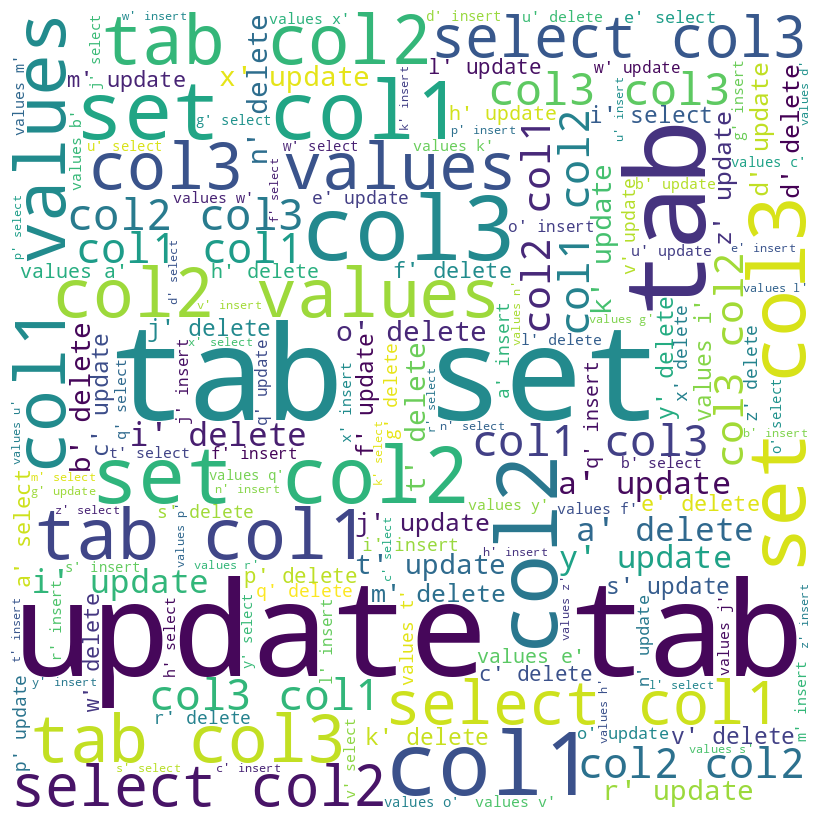

In [ ]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt


text_data = " ".join(worng['entry'])


wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = None,
                min_font_size = 10).generate(text_data)


plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()


In [ ]:
import re

In [ ]:


def check(query):
    patterns = [
      r"(?i)(?:union\s+select|select\s+.*?from\s+.*?where\s+.*?=\s*['\"].*?--)",
      r"(?i)(?:or\s+['\"].*?['\"]\s*=\s*['\"])",
      r"(?i)(?:;|--)",
      r"(?i)(?:exec\s*\(|xp_)",
      r"(?i)(?:drop\s+table|drop\s+database)",
      r"1'1",
      r"1 exec sp_ \(or exec xp_\)",
      r"1 and 1=1",
      r"1' and 1=\(select count\(\*\) from tablenames\); --",
      r"1 or 1=1",
      r"1' or '1'='1",
      r"1or1=1",
      r"1'or'1'='1",
      r"'-'",
      r"' '",
      r"'&'",
      r"'\^'",
      r"'\*'",
      r"' or ''-'",
      r"' or '' '",
      r"' or ''&'",
      r"' or ''\^'",
      r"' or ''\*'",
      r"-'",
      r"' '",
      r"'&'",
      r"'\^'",
      r"'\*'",
      r'" or ""-"',
      r'" or "" "',
      r'" or ""&"',
      r'" or ""\^"',
      r'" or ""\*"',
      r"or true--",
      r'" or true--',
      r"' or true--",
      r'") or true--',
      r"') or true--",
      r"' or 'x'='x",
      r"') or ('x')=('x",
      r"')) or (('x'))=(('x",
      r'" or "x"="x',
      r'") or ("x")=("x',
      r'")) or (("x"))=(("x',
      r"or 1=1",
      r"or 1=1--",
      r"or 1=1#"
    ]

    for pattern in patterns:
        if re.search(pattern, query):
            return True

    return False


In [ ]:
def predict_label(model, tokenizer, text, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):

    if(check(text)):
      return true


    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predicted_label = torch.argmax(logits, dim=1).cpu().numpy()[0]

    return predicted_label



In [ ]:
input_=str(input("String: "))
predict_label(model,tokenizer,input_)

String: dad


0